In this notebook, we test our models using all available features.
We tried: 
- logistic regression: with and without upsampling, with and without parameter search
- naive bayes: with and without upsampling
- KNN: with scaling, with and without upsampling
- random forest, with & without upsampling, with and without parameter search
- extreme gradiant boosting, without and without upsampling, with and without parameter search

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import time

import ipywidgets as widgets

from imblearn.over_sampling import SMOTE 

from sklearn.decomposition import PCA
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import PowerTransformer
from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import cross_val_score


from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import LogisticRegression
from xgboost import XGBClassifier

from sklearn.metrics import classification_report, confusion_matrix
from sklearn.metrics import f1_score

In [2]:
#Train/Test split
def split(X, y):
    X_train, X_test, y_train, y_test = train_test_split(
    X,
    y,
    test_size=0.2, 
    random_state=2024,
    stratify=y
    ) 
    return X_train, X_test, y_train, y_test

In [3]:
def select_cols_to_remove(df):
    # Create a list of column names
    column_names = df.columns.tolist()

    # Create the select menu
    select_cols = widgets.Select(
        options=column_names,
        rows=5,
        layout=widgets.Layout(width='50%')
    )

    # Create the button to add the selected column to a list
    add_button = widgets.Button(description='Add')
    remove_cols = []

    def add_col_to_list(b):
        col_name = select_cols.value
        if col_name not in remove_cols:
            remove_cols.append(col_name)
        print('Selected columns to remove:', remove_cols)

    add_button.on_click(add_col_to_list)

    # Display the select menu and button
    print("Select columns to remove:")
    display(select_cols)
    display(add_button)

    return remove_cols


In [4]:
def run_model(X_train, y_train, X_test, y_test, transformer=None, model=None, params=None, cv=None):
    # Timing how long the model takes to run
    start_time = time.time()
    
    
    # Create a pipeline with the transformer and model
    if transformer is None:
        pipe = Pipeline(steps=[('model', model)])
    else:
        pipe = Pipeline(steps=[('transformer', transformer), ('model', model)])
    
    # Use GridSearchCV to test different hyperparameters
    if params is None:
        grid = GridSearchCV(pipe, cv=cv, scoring='f1')
    else:
        grid = GridSearchCV(pipe, params, cv=cv, scoring='f1')

    # Fit the model
    grid.fit(X_train, y_train)
    
    # Get the best model and its hyperparameters
    best_model = grid.best_estimator_
    best_params = grid.best_params_
    
    # Calculate and print the F1 score for the training set (best model)
    y_train_pred = best_model.predict(X_train)
    train_f1_score = f1_score(y_train, y_train_pred)
    print(f"F1 score for the training set: {train_f1_score}")
    

    # Print the classification report and confusion matrix for the best set of hyperparameters
    print(f"Best parameters: {best_params}")
    print(f"Best F1 score: {grid.best_score_}")
    print("Classification report and confusion matrix for best model:")
    y_pred = best_model.predict(X_test)
    print(classification_report(y_test, y_pred))
    print(confusion_matrix(y_test, y_pred))
    
    # Calculate and print the F1 score for the test set (best model)
    test_f1_score = f1_score(y_test, y_pred)
    print(f"F1 score for the test set: {test_f1_score}")

    
    # Print the time taken to run the model
    end_time = time.time()
    print(f"Time taken to run: {round((end_time - start_time)/60,1)} minutes")

In [5]:
#function to plot the confusion matrix

def plot_confusion_matrix(y_test, y_pred, labels=['Fail', 'Success']):
    cm = confusion_matrix(y_test, y_pred)
    plt.figure(figsize=(8, 6))
    plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
    plt.title('Confusion Matrix')
    plt.colorbar()
    tick_marks = np.arange(len(labels))
    plt.xticks(tick_marks, labels, rotation=45)
    plt.yticks(tick_marks, labels)
    plt.xlabel('Predicted Label')
    plt.ylabel('True Label')

    # Add labels to each cell
    thresh = cm.max() / 2
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            plt.text(j, i, cm[i, j], ha='center', va='center',
                     color='white' if cm[i, j] > thresh else 'black')

    plt.tight_layout()
    plt.show()

## Start here

In [6]:
#Import the CSV
df = pd.read_csv('Data/indiepygo_final_.csv')

___________
If we want to remove some features. If not, please skip

In [ ]:
# IF NEEDED: Call the function to select columns to remove
cols_to_remove = select_cols_to_remove(df)

In [ ]:
# Create a new DataFrame with the remaining columns
df = df.drop(cols_to_remove, axis=1)

In [9]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20618 entries, 0 to 20617
Data columns (total 82 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   goal_usd            20618 non-null  float64
 1   australia           20618 non-null  int64  
 2   canada              20618 non-null  int64  
 3   switzerland         20618 non-null  int64  
 4   denmark             20618 non-null  int64  
 5   western_europe      20618 non-null  int64  
 6   great_britain       20618 non-null  int64  
 7   hong_kong           20618 non-null  int64  
 8   norway              20618 non-null  int64  
 9   sweden              20618 non-null  int64  
 10  singapore           20618 non-null  int64  
 11  united_states       20618 non-null  int64  
 12  jan                 20618 non-null  int64  
 13  feb                 20618 non-null  int64  
 14  mar                 20618 non-null  int64  
 15  apr                 20618 non-null  int64  
 16  may 

_________________
Here:

In [10]:
#Separate into X and Y
X = df.drop('is_success', axis=1)
y = df['is_success']

In [11]:
#train/test split
X_train, X_test, y_train, y_test = split(X,y)

In [12]:
#upsampling
#create an instance of SMOTE
smote = SMOTE(random_state=42)

#apply SMOTE to our unbalanced dataset. We apply only to train set.
X_train_resampled, y_train_resampled = smote.fit_resample(X_train, y_train)

### Random Forest

#### RF, no param search, no upsampling

F1 score for the training set: 0.99986366734833
Classification report and confusion matrix for best model:
              precision    recall  f1-score   support

           0       0.86      0.98      0.91      3207
           1       0.86      0.42      0.57       917

    accuracy                           0.86      4124
   macro avg       0.86      0.70      0.74      4124
weighted avg       0.86      0.86      0.84      4124

F1 score for the test set: 0.567883211678832


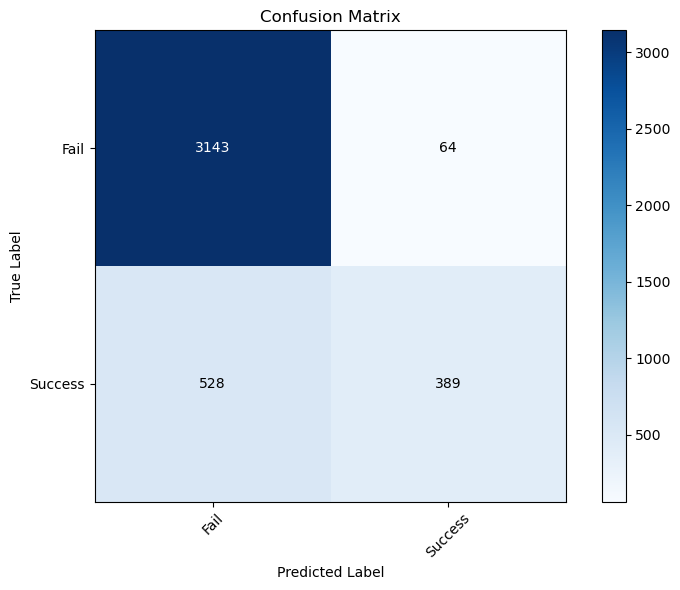

In [13]:
#Random Forest no param search

rfc = RandomForestClassifier()

# Fit the model
rfc.fit(X_train, y_train)
    
    
# Calculate and print the F1 score for the training set
y_train_pred = rfc.predict(X_train)
train_f1_score = f1_score(y_train, y_train_pred)
print(f"F1 score for the training set: {train_f1_score}")
    

# Print the classification report and confusion matrix for the best set of hyperparameters
print("Classification report and confusion matrix for best model:")
y_pred = rfc.predict(X_test)
print(classification_report(y_test, y_pred))

    
# Calculate and print the F1 score for the test set (best model)
test_f1_score = f1_score(y_test, y_pred)
print(f"F1 score for the test set: {test_f1_score}")
plot_confusion_matrix(y_test, y_pred)

#### RF + No Param Search + PT + No Upsampling

F1 score for the training set: 0.9997272975184074
Classification report and confusion matrix for best model:
              precision    recall  f1-score   support

           0       0.86      0.98      0.91      3207
           1       0.85      0.42      0.56       917

    accuracy                           0.85      4124
   macro avg       0.85      0.70      0.74      4124
weighted avg       0.85      0.85      0.84      4124

F1 score for the test set: 0.5643636363636364


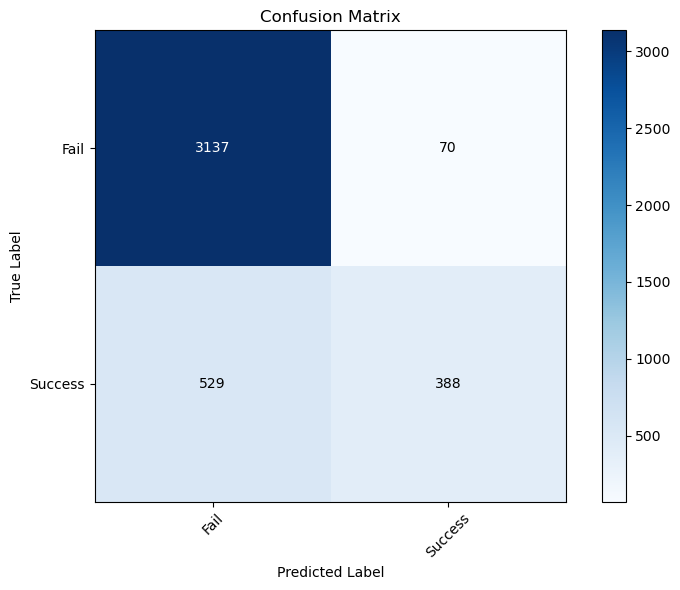

In [59]:
#Random Forest + PT
rfc = RandomForestClassifier()
pt = PowerTransformer()

pipe = Pipeline(steps=[('transformer', pt), ('model', rfc)])
pipe.fit(X_train, y_train)

# Calculate and print the F1 score for the training set
y_train_pred = pipe.predict(X_train)
train_f1_score = f1_score(y_train, y_train_pred)
print(f"F1 score for the training set: {train_f1_score}")
    

# Print the classification report and confusion matrix for the best set of hyperparameters
print("Classification report and confusion matrix for best model:")
y_pred = pipe.predict(X_test)
print(classification_report(y_test, y_pred))

    
# Calculate and print the F1 score for the test set (best model)
test_f1_score = f1_score(y_test, y_pred)
print(f"F1 score for the test set: {test_f1_score}")
plot_confusion_matrix(y_test, y_pred)

#### RF + No Param Search + Upsampling + No Transfo

F1 score for the training set: 0.9999610151651007
Classification report and confusion matrix for best model:
              precision    recall  f1-score   support

           0       0.86      0.97      0.91      3207
           1       0.81      0.44      0.57       917

    accuracy                           0.85      4124
   macro avg       0.83      0.70      0.74      4124
weighted avg       0.85      0.85      0.83      4124

F1 score for the test set: 0.5696113074204947


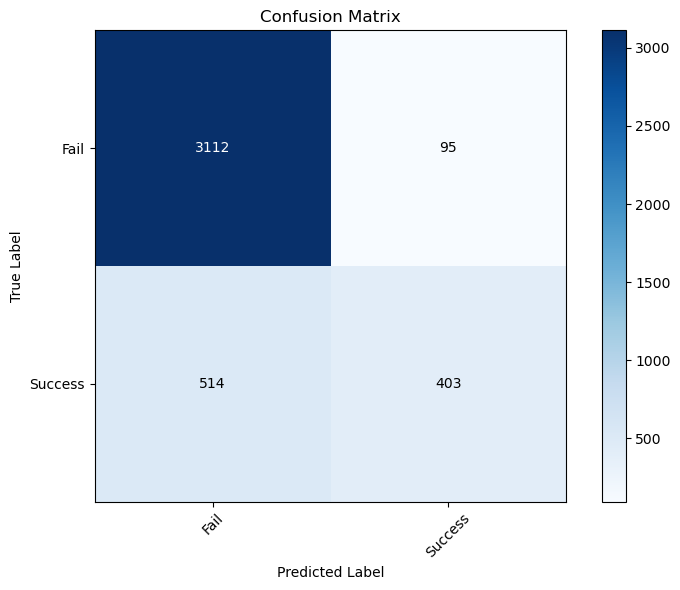

In [14]:
#Random Forest no param search

rfc = RandomForestClassifier()

# Fit the model
rfc.fit(X_train_resampled, y_train_resampled)
    
    
# Calculate and print the F1 score for the training set
y_train_pred = rfc.predict(X_train_resampled)
train_f1_score = f1_score(y_train_resampled, y_train_pred)
print(f"F1 score for the training set: {train_f1_score}")
    

# Print the classification report and confusion matrix for the best set of hyperparameters
print("Classification report and confusion matrix for best model:")
y_pred = rfc.predict(X_test)
print(classification_report(y_test, y_pred))

    
# Calculate and print the F1 score for the test set (best model)
test_f1_score = f1_score(y_test, y_pred)
print(f"F1 score for the test set: {test_f1_score}")
plot_confusion_matrix(y_test, y_pred)

#### RF + Upsampling + Param Search

In [60]:
#RandomForest
rfc = RandomForestClassifier()

params = {
    'model__n_estimators': [100, 200],
    'model__max_depth': [None, 5, 10],
    'model__min_samples_split': [2, 10],
    'model__min_samples_leaf': [1, 4],
    'model__max_features': ['sqrt', None],
    'model__class_weight': [None, {0: 1, 1: 5}]
}

run_model(X_train_resampled, y_train_resampled, X_test, y_test, model=rfc, params=params)

F1 score for the training set: 0.9999610182044985
Best parameters: {'model__class_weight': {0: 1, 1: 5}, 'model__max_depth': None, 'model__max_features': None, 'model__min_samples_leaf': 1, 'model__min_samples_split': 2, 'model__n_estimators': 100}
Best F1 score: 0.8618730530110439
Classification report and confusion matrix for best model:
              precision    recall  f1-score   support

           0       0.86      0.96      0.90      3207
           1       0.74      0.44      0.55       917

    accuracy                           0.84      4124
   macro avg       0.80      0.70      0.73      4124
weighted avg       0.83      0.84      0.83      4124

[[3069  138]
 [ 514  403]]
F1 score for the test set: 0.5528120713305898
Time taken to run: 45.6 minutes


#### BEST RANDOM FOREST

In [ ]:
#Best Random Forest

best_rf = RandomForestClassifier(max_depth=None, n_estimators=200, class_weight = {0: 1, 1: 5}, max_features=None)

best_rf.fit(X_train, y_train)

rf_y_hat_train2 = best_rf.predict(X_train)
rf_y_hat_test2 = best_rf.predict(X_test)
 

In [ ]:
# Plotting feature importance
n_features = X_train.shape[1]
plt.figure(figsize=(8,20))
plt.barh(range(n_features), best_rf.feature_importances_, align='center') 
plt.yticks(np.arange(n_features), X_train.columns.values) 
plt.title("Feature importances in the best Random Forest model")
plt.xlabel("Feature importance")
plt.ylabel("Feature")
plt.show()

### Logistic Regression

#### LG + No Param Search + No Upsampling + No Transfo

F1 score for the training set: 0.4814305364511692
Classification report and confusion matrix for best model:
              precision    recall  f1-score   support

           0       0.84      0.98      0.90      3207
           1       0.84      0.34      0.48       917

    accuracy                           0.84      4124
   macro avg       0.84      0.66      0.69      4124
weighted avg       0.84      0.84      0.81      4124

F1 score for the test set: 0.4832944832944834


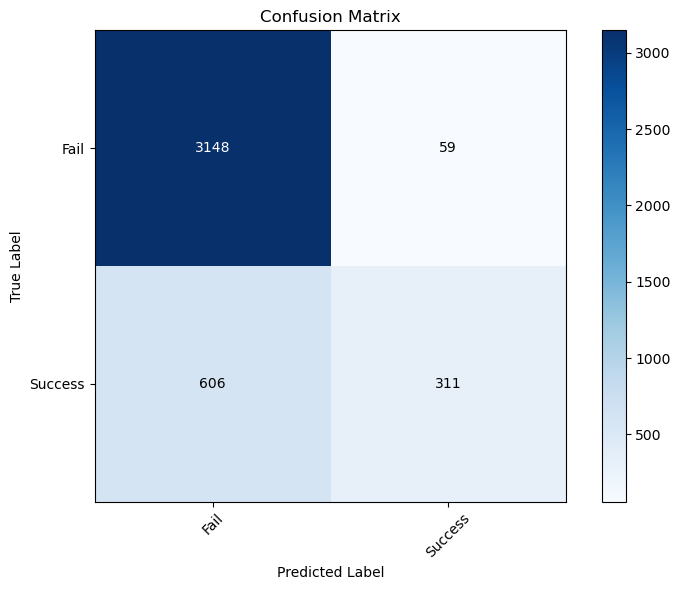

In [17]:
lr = LogisticRegression()

# Fit the model
lr.fit(X_train, y_train)
    
    
# Calculate and print the F1 score for the training set
y_train_pred = lr.predict(X_train)
train_f1_score = f1_score(y_train, y_train_pred)
print(f"F1 score for the training set: {train_f1_score}")
    

# Print the classification report and confusion matrix for the best set of hyperparameters
print("Classification report and confusion matrix for best model:")
y_pred = lr.predict(X_test)
print(classification_report(y_test, y_pred))

    
# Calculate and print the F1 score for the test set (best model)
test_f1_score = f1_score(y_test, y_pred)
print(f"F1 score for the test set: {test_f1_score}")
plot_confusion_matrix(y_test, y_pred)


#### LR + No Param Search + Upsampling + No Transfo

F1 score for the training set: 0.6372142217883003
Classification report and confusion matrix for best model:
              precision    recall  f1-score   support

           0       0.87      0.68      0.76      3207
           1       0.36      0.63      0.46       917

    accuracy                           0.67      4124
   macro avg       0.61      0.66      0.61      4124
weighted avg       0.75      0.67      0.70      4124

F1 score for the test set: 0.4587155963302752


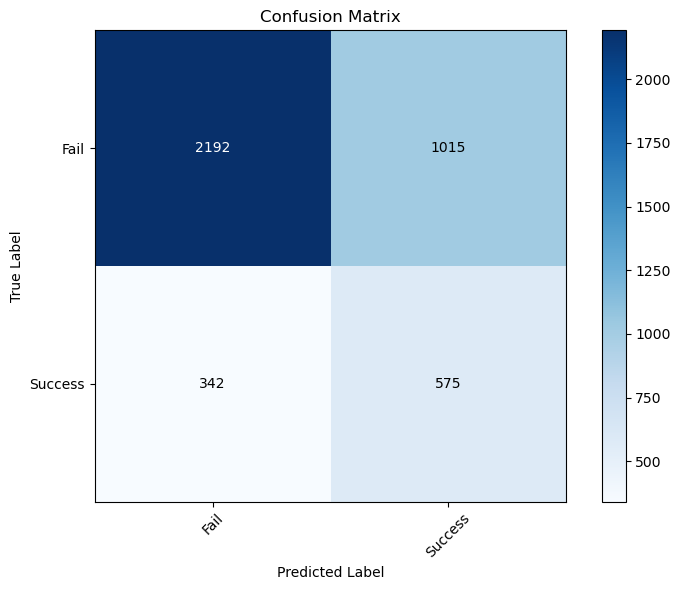

In [18]:
lr = LogisticRegression()

# Fit the model
lr.fit(X_train_resampled, y_train_resampled)
    
    
# Calculate and print the F1 score for the training set
y_train_pred = lr.predict(X_train_resampled)
train_f1_score = f1_score(y_train_resampled, y_train_pred)
print(f"F1 score for the training set: {train_f1_score}")
    

# Print the classification report and confusion matrix for the best set of hyperparameters
print("Classification report and confusion matrix for best model:")
y_pred = lr.predict(X_test)
print(classification_report(y_test, y_pred))

    
# Calculate and print the F1 score for the test set (best model)
test_f1_score = f1_score(y_test, y_pred)
print(f"F1 score for the test set: {test_f1_score}")
plot_confusion_matrix(y_test, y_pred)

#### Logistic Regression + PT + Upsampling

F1 score for the training set: 0.888538729474208
Classification report and confusion matrix for best model:
              precision    recall  f1-score   support

           0       0.85      0.96      0.90      3207
           1       0.75      0.43      0.55       917

    accuracy                           0.84      4124
   macro avg       0.80      0.69      0.72      4124
weighted avg       0.83      0.84      0.82      4124

F1 score for the test set: 0.5450762829403606


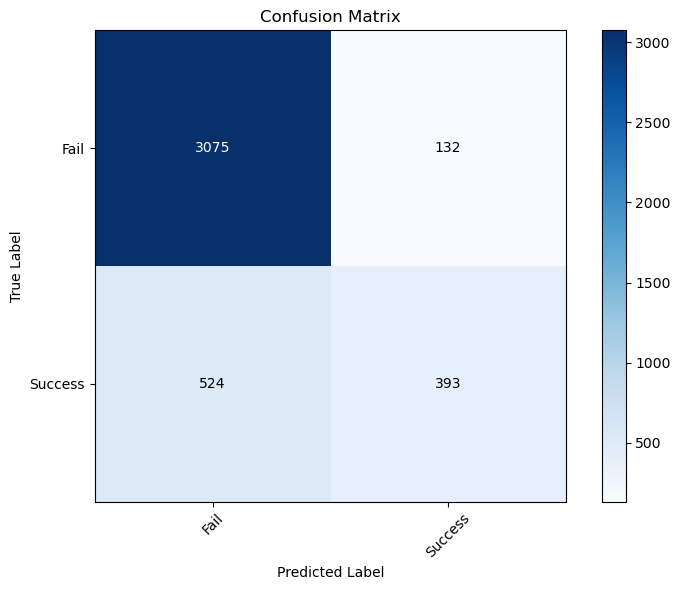

In [21]:
#Logistic Regression + PT
lr = LogisticRegression()
pt = PowerTransformer()

pipe = Pipeline(steps=[('transformer', pt), ('model', lr)])
pipe.fit(X_train_resampled, y_train_resampled)

# Calculate and print the F1 score for the training set
y_train_pred = pipe.predict(X_train_resampled)
train_f1_score = f1_score(y_train_resampled, y_train_pred)
print(f"F1 score for the training set: {train_f1_score}")
    

# Print the classification report and confusion matrix for the best set of hyperparameters
print("Classification report and confusion matrix for best model:")
y_pred = pipe.predict(X_test)
print(classification_report(y_test, y_pred))

    
# Calculate and print the F1 score for the test set (best model)
test_f1_score = f1_score(y_test, y_pred)
print(f"F1 score for the test set: {test_f1_score}")
plot_confusion_matrix(y_test, y_pred)

#### Logistic Regression + PT + No Upsampling + No Param Search

F1 score for the training set: 0.5404005524861878
Classification report and confusion matrix for best model:
              precision    recall  f1-score   support

           0       0.85      0.96      0.90      3207
           1       0.75      0.42      0.54       917

    accuracy                           0.84      4124
   macro avg       0.80      0.69      0.72      4124
weighted avg       0.83      0.84      0.82      4124

F1 score for the test set: 0.5380852550663872


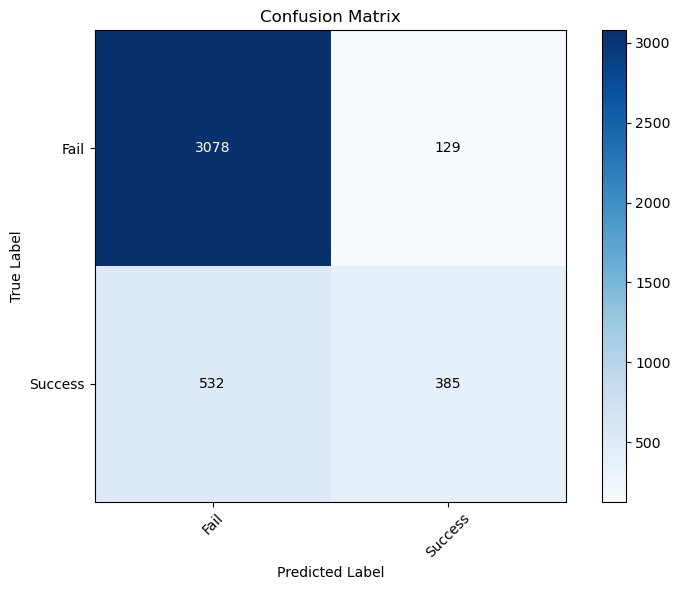

In [25]:
#Logistic Regression + PT + no upsampling
lr = LogisticRegression()
pt = PowerTransformer()

pipe = Pipeline(steps=[('transformer', pt), ('model', lr)])
pipe.fit(X_train, y_train)

# Calculate and print the F1 score for the training set
y_train_pred = pipe.predict(X_train)
train_f1_score = f1_score(y_train, y_train_pred)
print(f"F1 score for the training set: {train_f1_score}")
    

# Print the classification report and confusion matrix for the best set of hyperparameters
print("Classification report and confusion matrix for best model:")
y_pred = pipe.predict(X_test)
print(classification_report(y_test, y_pred))

    
# Calculate and print the F1 score for the test set (best model)
test_f1_score = f1_score(y_test, y_pred)
print(f"F1 score for the test set: {test_f1_score}")
plot_confusion_matrix(y_test, y_pred)

#### Logistic Regression with StandardScaler + No upsampling

F1 score for the training set: 0.5230446927374303
Classification report and confusion matrix for best model:
              precision    recall  f1-score   support

           0       0.85      0.96      0.90      3207
           1       0.74      0.41      0.53       917

    accuracy                           0.84      4124
   macro avg       0.79      0.68      0.71      4124
weighted avg       0.82      0.84      0.82      4124

F1 score for the test set: 0.5259467040673212


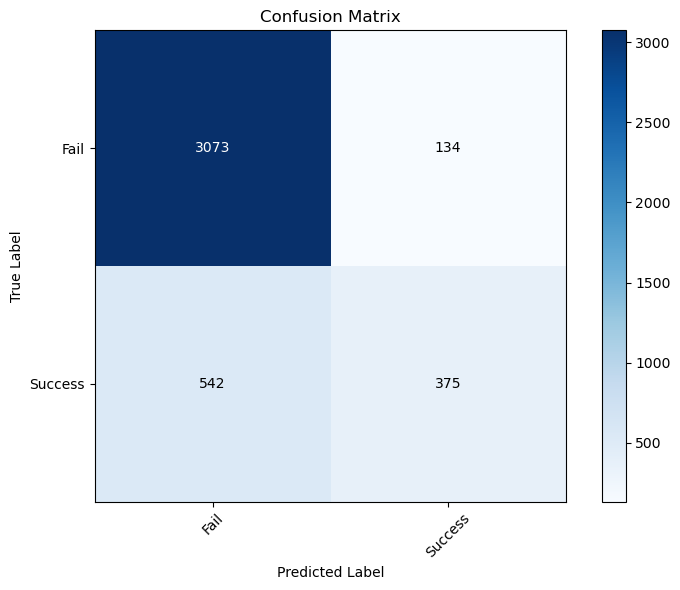

In [30]:
#Logistic Regression + StandardScaler
lr = LogisticRegression()
ss = StandardScaler()

pipe = Pipeline(steps=[('transformer', ss), ('model', lr)])
pipe.fit(X_train, y_train)

# Calculate and print the F1 score for the training set
y_train_pred = pipe.predict(X_train)
train_f1_score = f1_score(y_train, y_train_pred)
print(f"F1 score for the training set: {train_f1_score}")
    

# Print the classification report and confusion matrix for the best set of hyperparameters
print("Classification report and confusion matrix for best model:")
y_pred = pipe.predict(X_test)
print(classification_report(y_test, y_pred))

    
# Calculate and print the F1 score for the test set (best model)
test_f1_score = f1_score(y_test, y_pred)
print(f"F1 score for the test set: {test_f1_score}")
plot_confusion_matrix(y_test, y_pred)

#### LR +  Upsampling +PowerTransformer (=Best) + Param Search

In [27]:
lr = LogisticRegression()
pt = PowerTransformer()

params = {'model__penalty': [None, 'l2', 'l1'],
        'model__solver': ['lbfgs', 'newton-cg', 'liblinear'],
        'model__C': [0.1, 1, 10] 
         }

run_model(X_train_resampled, y_train_resampled, X_test, y_test, transformer=pt, model=lr, params=params)

/Users/juliettedegoul/opt/anaconda3/lib/python3.9/site-packages/sklearn/preprocessing/_data.py:3253: RuntimeWarning: divide by zero encountered in log
  loglike = -n_samples / 2 * np.log(x_trans.var())
/Users/juliettedegoul/opt/anaconda3/lib/python3.9/site-packages/sklearn/preprocessing/_data.py:3253: RuntimeWarning: divide by zero encountered in log
  loglike = -n_samples / 2 * np.log(x_trans.var())
/Users/juliettedegoul/opt/anaconda3/lib/python3.9/site-packages/sklearn/preprocessing/_data.py:3253: RuntimeWarning: divide by zero encountered in log
  loglike = -n_samples / 2 * np.log(x_trans.var())
/Users/juliettedegoul/opt/anaconda3/lib/python3.9/site-packages/sklearn/preprocessing/_data.py:3253: RuntimeWarning: divide by zero encountered in log
  loglike = -n_samples / 2 * np.log(x_trans.var())
/Users/juliettedegoul/opt/anaconda3/lib/python3.9/site-packages/sklearn/preprocessing/_data.py:3253: RuntimeWarning: divide by zero encountered in log
  loglike = -n_samples / 2 * np.log(x_tra

F1 score for the training set: 0.8885755753680282
Best parameters: {'model__C': 10, 'model__penalty': 'l1', 'model__solver': 'liblinear'}
Best F1 score: 0.8315650930669356
Classification report and confusion matrix for best model:
              precision    recall  f1-score   support

           0       0.85      0.96      0.90      3207
           1       0.75      0.43      0.54       917

    accuracy                           0.84      4124
   macro avg       0.80      0.69      0.72      4124
weighted avg       0.83      0.84      0.82      4124

[[3075  132]
 [ 525  392]]
F1 score for the test set: 0.5440666204024983
Time taken to run: 3.6 minutes


/Users/juliettedegoul/opt/anaconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


#### Best Logistic Regression: PT + No Param Search + Upsampling

              precision    recall  f1-score   support

           0       0.85      0.96      0.90      3207
           1       0.75      0.43      0.55       917

    accuracy                           0.84      4124
   macro avg       0.80      0.69      0.72      4124
weighted avg       0.83      0.84      0.82      4124



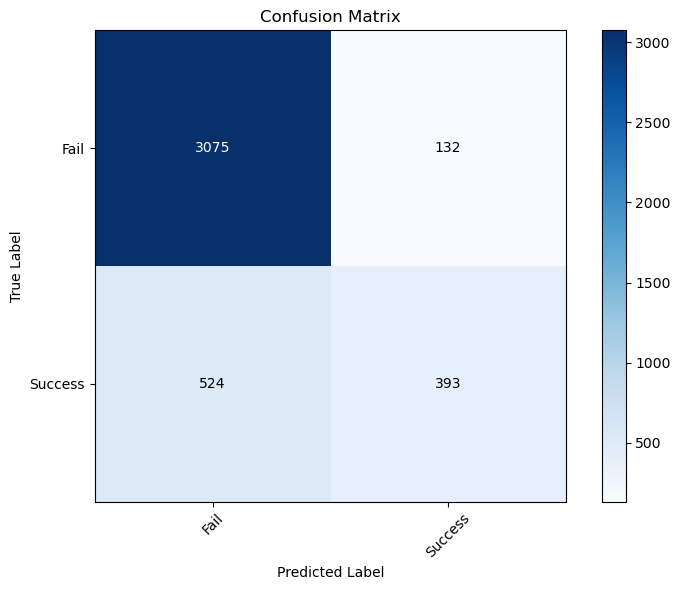

In [31]:
best_lr = LogisticRegression()
pt = PowerTransformer()

pipe = Pipeline(steps=[('transformer', pt), ('model', best_lr)])
pipe.fit(X_train_resampled, y_train_resampled)


y_pred = pipe.predict(X_test)
print(classification_report(y_test, y_pred))
plot_confusion_matrix(y_test, y_pred)


### KNN

#### KNN + No Param Search + MinMaxScaler (distance algorithms are sensitive to scale and minmax eprformed better than PT and StandardScaler) + No Upsampling

/Users/juliettedegoul/opt/anaconda3/lib/python3.9/site-packages/sklearn/neighbors/_classification.py:228: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims` to True or False to avoid this warning.
  mode, _ = stats.mode(_y[neigh_ind, k], axis=1)


F1 score for the training set: 0.6257606490872211
Classification report and confusion matrix for best model:


/Users/juliettedegoul/opt/anaconda3/lib/python3.9/site-packages/sklearn/neighbors/_classification.py:228: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims` to True or False to avoid this warning.
  mode, _ = stats.mode(_y[neigh_ind, k], axis=1)


              precision    recall  f1-score   support

           0       0.85      0.94      0.89      3207
           1       0.68      0.41      0.51       917

    accuracy                           0.83      4124
   macro avg       0.76      0.68      0.70      4124
weighted avg       0.81      0.83      0.81      4124

F1 score for the test set: 0.5091899251191286


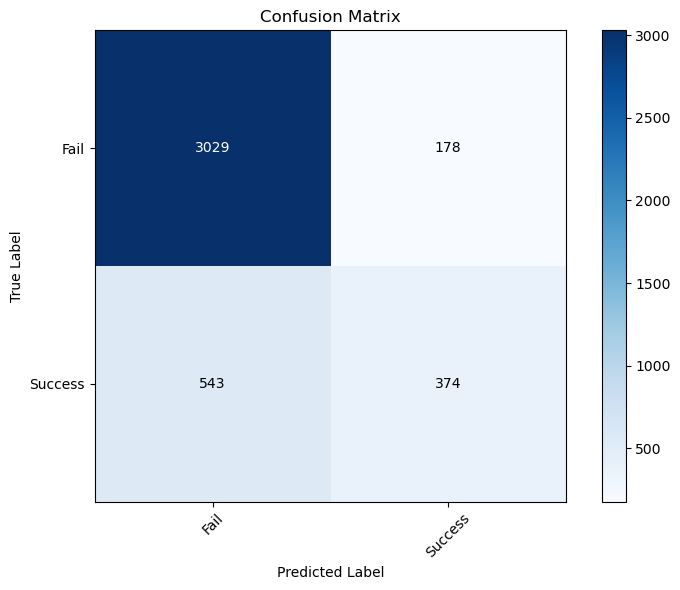

In [37]:
#KNN + MinMax
knn = KNeighborsClassifier()
mm = MinMaxScaler()

pipe = Pipeline(steps=[('transformer', mm), ('model', knn)])
pipe.fit(X_train, y_train)

# Calculate and print the F1 score for the training set
y_train_pred = pipe.predict(X_train)
train_f1_score = f1_score(y_train, y_train_pred)
print(f"F1 score for the training set: {train_f1_score}")
    

# Print the classification report and confusion matrix for the best set of hyperparameters
print("Classification report and confusion matrix for best model:")
y_pred = pipe.predict(X_test)
print(classification_report(y_test, y_pred))

    
# Calculate and print the F1 score for the test set (best model)
test_f1_score = f1_score(y_test, y_pred)
print(f"F1 score for the test set: {test_f1_score}")
plot_confusion_matrix(y_test, y_pred)

#### KNN + No Param Search + No Upsampling + No Transfo

/Users/juliettedegoul/opt/anaconda3/lib/python3.9/site-packages/sklearn/neighbors/_classification.py:228: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims` to True or False to avoid this warning.
  mode, _ = stats.mode(_y[neigh_ind, k], axis=1)


F1 score for the training set: 0.6228799467908214
Classification report and confusion matrix:


/Users/juliettedegoul/opt/anaconda3/lib/python3.9/site-packages/sklearn/neighbors/_classification.py:228: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims` to True or False to avoid this warning.
  mode, _ = stats.mode(_y[neigh_ind, k], axis=1)


              precision    recall  f1-score   support

           0       0.84      0.93      0.88      3207
           1       0.61      0.38      0.47       917

    accuracy                           0.81      4124
   macro avg       0.73      0.66      0.68      4124
weighted avg       0.79      0.81      0.79      4124

F1 score for the test set: 0.4694014794889038


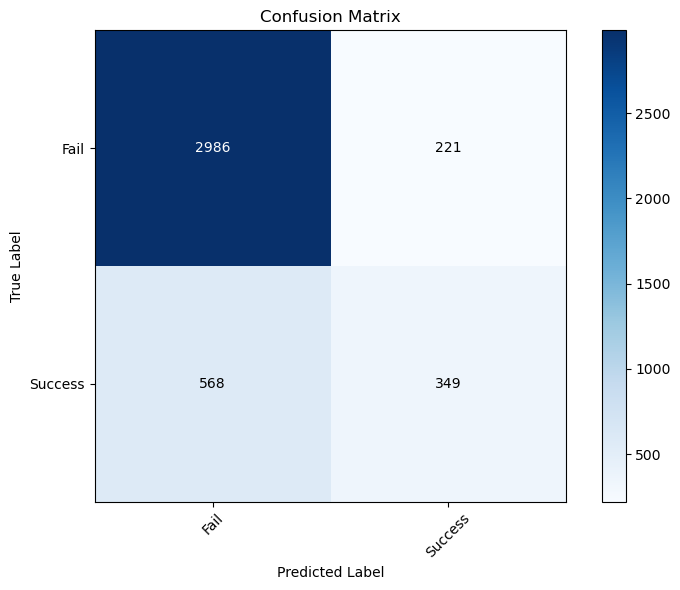

In [33]:
knn = KNeighborsClassifier()

# Fit the model
knn.fit(X_train, y_train)
    
    
# Calculate and print the F1 score for the training set
y_train_pred = knn.predict(X_train)
train_f1_score = f1_score(y_train, y_train_pred)
print(f"F1 score for the training set: {train_f1_score}")
    

# Print the classification report and confusion matrix for the best set of hyperparameters
print("Classification report and confusion matrix:")
y_pred = knn.predict(X_test)
print(classification_report(y_test, y_pred))

    
# Calculate and print the F1 score for the test set (best model)
test_f1_score = f1_score(y_test, y_pred)
print(f"F1 score for the test set: {test_f1_score}")
plot_confusion_matrix(y_test, y_pred)


#### KNN + No Param Search + Upsampling + No Transfo

/Users/juliettedegoul/opt/anaconda3/lib/python3.9/site-packages/sklearn/neighbors/_classification.py:228: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims` to True or False to avoid this warning.
  mode, _ = stats.mode(_y[neigh_ind, k], axis=1)


F1 score for the training set: 0.8579213422722547
Classification report and confusion matrix:


/Users/juliettedegoul/opt/anaconda3/lib/python3.9/site-packages/sklearn/neighbors/_classification.py:228: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims` to True or False to avoid this warning.
  mode, _ = stats.mode(_y[neigh_ind, k], axis=1)


              precision    recall  f1-score   support

           0       0.88      0.67      0.76      3207
           1       0.37      0.68      0.48       917

    accuracy                           0.67      4124
   macro avg       0.62      0.67      0.62      4124
weighted avg       0.77      0.67      0.70      4124

F1 score for the test set: 0.479046520569012


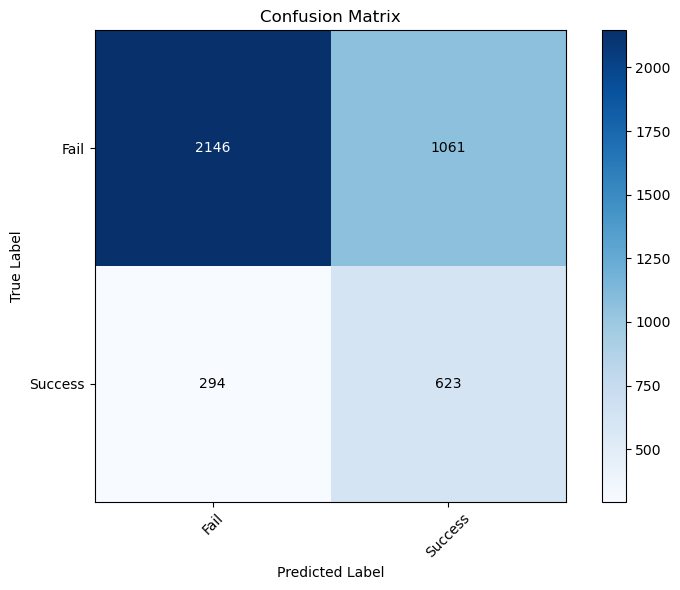

In [34]:
# Fit the model
knn.fit(X_train_resampled, y_train_resampled)
    
    
# Calculate and print the F1 score for the training set
y_train_pred = knn.predict(X_train_resampled)
train_f1_score = f1_score(y_train_resampled, y_train_pred)
print(f"F1 score for the training set: {train_f1_score}")
    

# Print the classification report and confusion matrix for the best set of hyperparameters
print("Classification report and confusion matrix:")
y_pred = knn.predict(X_test)
print(classification_report(y_test, y_pred))

    
# Calculate and print the F1 score for the test set (best model)
test_f1_score = f1_score(y_test, y_pred)
print(f"F1 score for the test set: {test_f1_score}")
plot_confusion_matrix(y_test, y_pred)

#### KNN + MinMax + Upsampling

/Users/juliettedegoul/opt/anaconda3/lib/python3.9/site-packages/sklearn/neighbors/_classification.py:228: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims` to True or False to avoid this warning.
  mode, _ = stats.mode(_y[neigh_ind, k], axis=1)


F1 score for the training set: 0.9038931879234995
Classification report and confusion matrix for best model:


/Users/juliettedegoul/opt/anaconda3/lib/python3.9/site-packages/sklearn/neighbors/_classification.py:228: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims` to True or False to avoid this warning.
  mode, _ = stats.mode(_y[neigh_ind, k], axis=1)


              precision    recall  f1-score   support

           0       0.86      0.89      0.87      3207
           1       0.54      0.48      0.51       917

    accuracy                           0.79      4124
   macro avg       0.70      0.68      0.69      4124
weighted avg       0.79      0.79      0.79      4124

F1 score for the test set: 0.5069767441860464


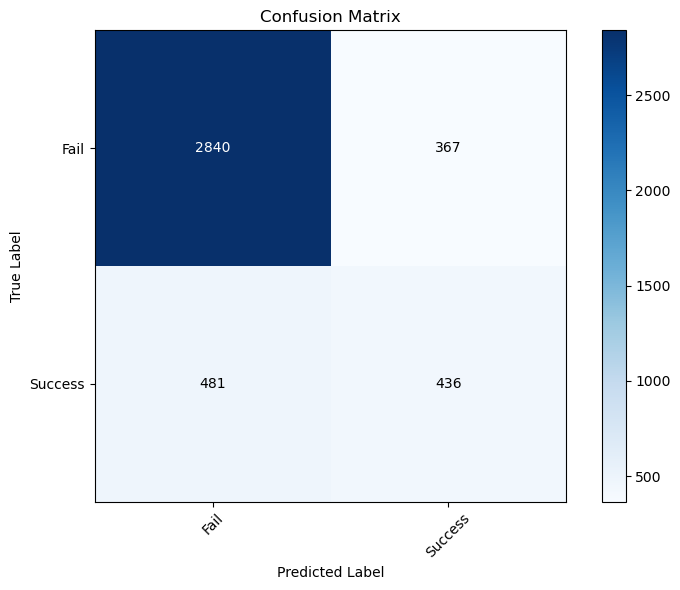

In [39]:
#KNN + MinMax
knn = KNeighborsClassifier()
mm = MinMaxScaler()

pipe = Pipeline(steps=[('transformer', mm), ('model', knn)])
pipe.fit(X_train_resampled, y_train_resampled)

# Calculate and print the F1 score for the training set
y_train_pred = pipe.predict(X_train_resampled)
train_f1_score = f1_score(y_train_resampled, y_train_pred)
print(f"F1 score for the training set: {train_f1_score}")
    

# Print the classification report and confusion matrix for the best set of hyperparameters
print("Classification report and confusion matrix for best model:")
y_pred = pipe.predict(X_test)
print(classification_report(y_test, y_pred))

    
# Calculate and print the F1 score for the test set (best model)
test_f1_score = f1_score(y_test, y_pred)
print(f"F1 score for the test set: {test_f1_score}")
plot_confusion_matrix(y_test, y_pred)

#### Best KNN: with minmaxscaler + no upsampling 

### Naive Bayes

#### NB + No Param Search + No Upsampling + No Transfo

F1 score for the training set: 0.4794229953330505
Classification report and confusion matrix:
              precision    recall  f1-score   support

           0       0.87      0.71      0.78      3207
           1       0.38      0.62      0.47       917

    accuracy                           0.69      4124
   macro avg       0.63      0.67      0.63      4124
weighted avg       0.76      0.69      0.71      4124

F1 score for the test set: 0.4743377483443708


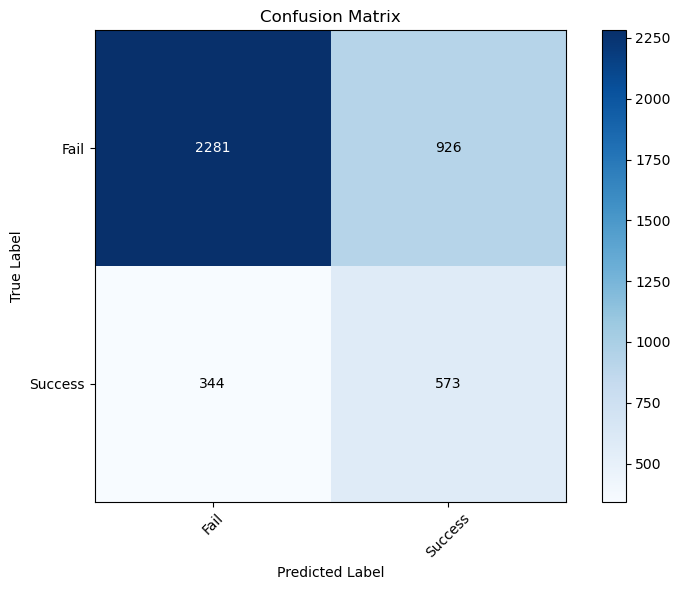

In [41]:
#NB no param search

mnb = MultinomialNB()

# Fit the model
mnb.fit(X_train, y_train)
    
    
# Calculate and print the F1 score for the training set
y_train_pred = mnb.predict(X_train)
train_f1_score = f1_score(y_train, y_train_pred)
print(f"F1 score for the training set: {train_f1_score}")
    

# Print the classification report and confusion matrix for the best set of hyperparameters
print("Classification report and confusion matrix:")
y_pred = mnb.predict(X_test)
print(classification_report(y_test, y_pred))

    
# Calculate and print the F1 score for the test set (best model)
test_f1_score = f1_score(y_test, y_pred)
print(f"F1 score for the test set: {test_f1_score}")
plot_confusion_matrix(y_test, y_pred)

#### NB + Upsampling + No Transfo + No Param Search

F1 score for the training set: 0.7027813436029097
Classification report and confusion matrix:
              precision    recall  f1-score   support

           0       0.85      0.82      0.83      3207
           1       0.44      0.51      0.47       917

    accuracy                           0.75      4124
   macro avg       0.65      0.66      0.65      4124
weighted avg       0.76      0.75      0.75      4124

F1 score for the test set: 0.471841704718417


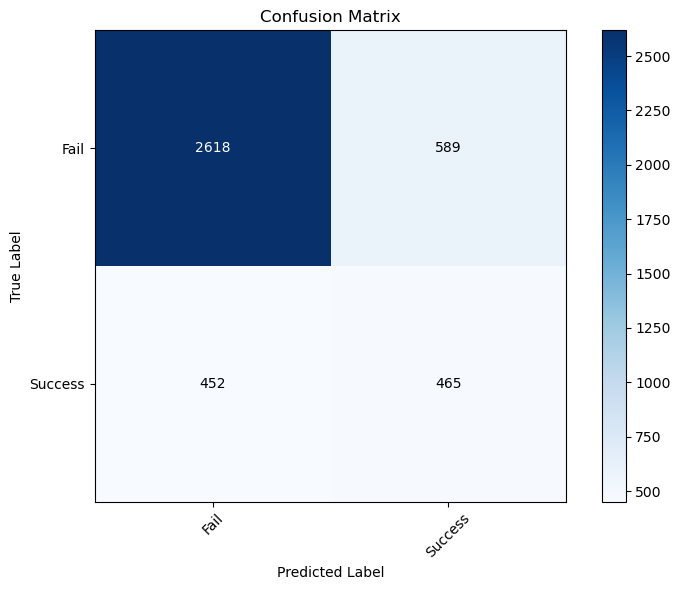

In [42]:
#NB no param search

mnb = MultinomialNB()

# Fit the model
mnb.fit(X_train_resampled, y_train_resampled)
    
    
# Calculate and print the F1 score for the training set
y_train_pred = mnb.predict(X_train_resampled)
train_f1_score = f1_score(y_train_resampled, y_train_pred)
print(f"F1 score for the training set: {train_f1_score}")
    

# Print the classification report and confusion matrix for the best set of hyperparameters
print("Classification report and confusion matrix:")
y_pred = mnb.predict(X_test)
print(classification_report(y_test, y_pred))

    
# Calculate and print the F1 score for the test set (best model)
test_f1_score = f1_score(y_test, y_pred)
print(f"F1 score for the test set: {test_f1_score}")
plot_confusion_matrix(y_test, y_pred)

### Extreme Gradiant Boosting

#### XGBoost + No Param Search + No transfo + No Upsampling

F1 score for the training set: 0.7770907907582167
Classification report and confusion matrix:
              precision    recall  f1-score   support

           0       0.88      0.97      0.92      3207
           1       0.84      0.52      0.64       917

    accuracy                           0.87      4124
   macro avg       0.86      0.75      0.78      4124
weighted avg       0.87      0.87      0.86      4124

F1 score for the test set: 0.6429051782111634


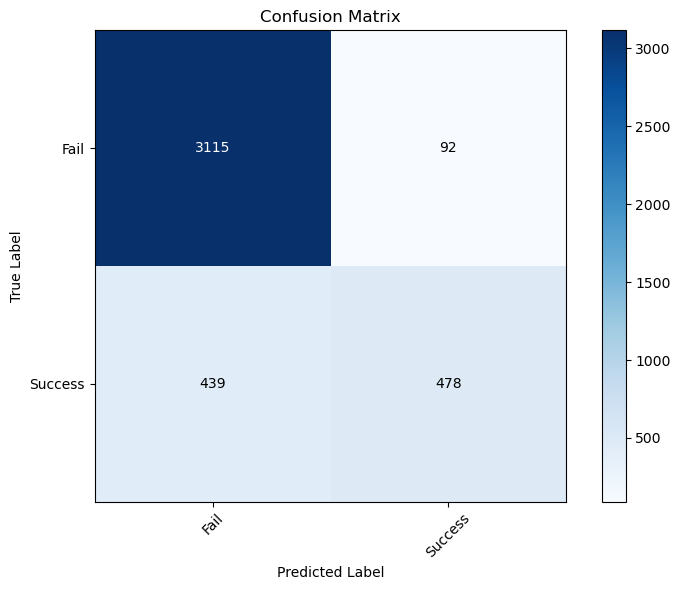

In [45]:
#XGB no param search

xgb = XGBClassifier()

# Fit the model
xgb.fit(X_train, y_train)
    
    
# Calculate and print the F1 score for the training set
y_train_pred = xgb.predict(X_train)
train_f1_score = f1_score(y_train, y_train_pred)
print(f"F1 score for the training set: {train_f1_score}")
    

# Print the classification report and confusion matrix for the best set of hyperparameters
print("Classification report and confusion matrix:")
y_pred = xgb.predict(X_test)
print(classification_report(y_test, y_pred))

    
# Calculate and print the F1 score for the test set (best model)
test_f1_score = f1_score(y_test, y_pred)
print(f"F1 score for the test set: {test_f1_score}")
plot_confusion_matrix(y_test, y_pred)



#### XGBoost + No Param Search + No Transfo + Upsampling

F1 score for the training set: 0.945158002038736
Classification report and confusion matrix:
              precision    recall  f1-score   support

           0       0.87      0.96      0.91      3207
           1       0.77      0.49      0.60       917

    accuracy                           0.85      4124
   macro avg       0.82      0.72      0.75      4124
weighted avg       0.84      0.85      0.84      4124

F1 score for the test set: 0.596


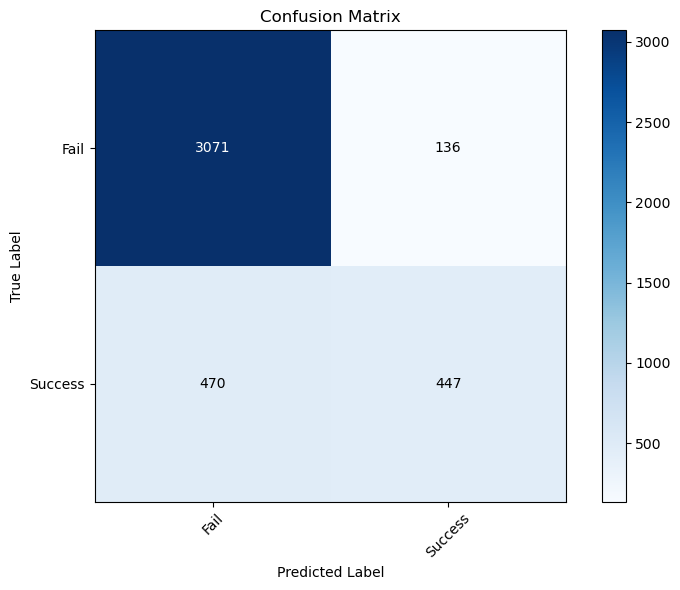

In [46]:
#XGB no param search with upsampling

xgb = XGBClassifier()

# Fit the model
xgb.fit(X_train_resampled, y_train_resampled)
    
    
# Calculate and print the F1 score for the training set
y_train_pred = xgb.predict(X_train_resampled)
train_f1_score = f1_score(y_train_resampled, y_train_pred)
print(f"F1 score for the training set: {train_f1_score}")
    

# Print the classification report and confusion matrix for the best set of hyperparameters
print("Classification report and confusion matrix:")
y_pred = xgb.predict(X_test)
print(classification_report(y_test, y_pred))

    
# Calculate and print the F1 score for the test set (best model)
test_f1_score = f1_score(y_test, y_pred)
print(f"F1 score for the test set: {test_f1_score}")
plot_confusion_matrix(y_test, y_pred)

#### XGB + PT + No up + No Param

F1 score for the training set: 0.7770907907582167
Classification report and confusion matrix for best model:
              precision    recall  f1-score   support

           0       0.88      0.97      0.92      3207
           1       0.84      0.52      0.64       917

    accuracy                           0.87      4124
   macro avg       0.86      0.75      0.78      4124
weighted avg       0.87      0.87      0.86      4124

F1 score for the test set: 0.6433378196500673


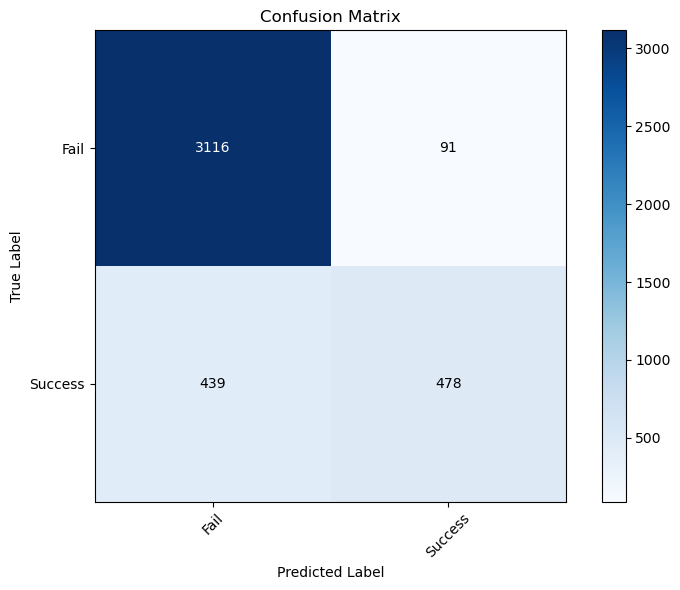

In [52]:
xgb = XGBClassifier()
pt = PowerTransformer()

pipe = Pipeline(steps=[('transformer', pt), ('model', xgb)])
pipe.fit(X_train, y_train)

# Calculate and print the F1 score for the training set
y_train_pred = pipe.predict(X_train)
train_f1_score = f1_score(y_train, y_train_pred)
print(f"F1 score for the training set: {train_f1_score}")
    

# Print the classification report and confusion matrix for the best set of hyperparameters
print("Classification report and confusion matrix for best model:")
y_pred = pipe.predict(X_test)
print(classification_report(y_test, y_pred))

    
# Calculate and print the F1 score for the test set (best model)
test_f1_score = f1_score(y_test, y_pred)
print(f"F1 score for the test set: {test_f1_score}")
plot_confusion_matrix(y_test, y_pred)

#### XGB + Upsampling + PT + No Param Search

F1 score for the training set: 0.945158002038736
Classification report and confusion matrix for best model:
              precision    recall  f1-score   support

           0       0.87      0.96      0.91      3207
           1       0.77      0.49      0.60       917

    accuracy                           0.85      4124
   macro avg       0.82      0.72      0.75      4124
weighted avg       0.84      0.85      0.84      4124

F1 score for the test set: 0.596


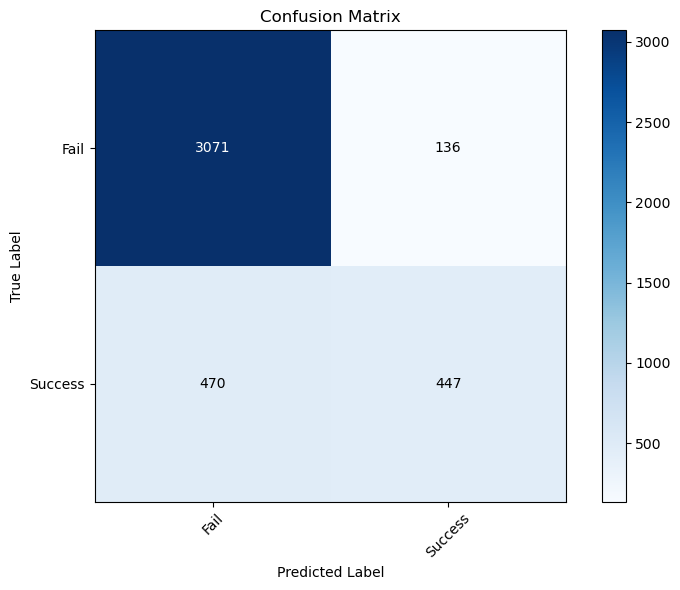

In [53]:
xgb = XGBClassifier()
pt = PowerTransformer()

pipe = Pipeline(steps=[('transformer', pt), ('model', xgb)])
pipe.fit(X_train_resampled, y_train_resampled)

# Calculate and print the F1 score for the training set
y_train_pred = pipe.predict(X_train_resampled)
train_f1_score = f1_score(y_train_resampled, y_train_pred)
print(f"F1 score for the training set: {train_f1_score}")
    

# Print the classification report and confusion matrix for the best set of hyperparameters
print("Classification report and confusion matrix for best model:")
y_pred = pipe.predict(X_test)
print(classification_report(y_test, y_pred))

    
# Calculate and print the F1 score for the test set (best model)
test_f1_score = f1_score(y_test, y_pred)
print(f"F1 score for the test set: {test_f1_score}")
plot_confusion_matrix(y_test, y_pred)

#### XGBoost + Param Search + No Upsampling + PT

In [55]:
xgb = XGBClassifier()
pt = PowerTransformer()

params = {'model__max_depth': [10, 20],
          'model__learning_rate': [0.1, 0.01],
          'model__n_estimators': [100, 200],
          'model__scale_pos_weight': [1, 3],
          #'model__reg_alpha': [0.1, 1],
          #'model__reg_lambda': [0.1, 1]
         }

run_model(X_train, y_train, X_test, y_test, transformer=pt, model=xgb, params=params, cv=5)

/Users/juliettedegoul/opt/anaconda3/lib/python3.9/site-packages/sklearn/preprocessing/_data.py:3253: RuntimeWarning: divide by zero encountered in log
  loglike = -n_samples / 2 * np.log(x_trans.var())
/Users/juliettedegoul/opt/anaconda3/lib/python3.9/site-packages/sklearn/preprocessing/_data.py:3253: RuntimeWarning: divide by zero encountered in log
  loglike = -n_samples / 2 * np.log(x_trans.var())
/Users/juliettedegoul/opt/anaconda3/lib/python3.9/site-packages/sklearn/preprocessing/_data.py:3253: RuntimeWarning: divide by zero encountered in log
  loglike = -n_samples / 2 * np.log(x_trans.var())
/Users/juliettedegoul/opt/anaconda3/lib/python3.9/site-packages/sklearn/preprocessing/_data.py:3253: RuntimeWarning: divide by zero encountered in log
  loglike = -n_samples / 2 * np.log(x_trans.var())
/Users/juliettedegoul/opt/anaconda3/lib/python3.9/site-packages/sklearn/preprocessing/_data.py:3253: RuntimeWarning: divide by zero encountered in log
  loglike = -n_samples / 2 * np.log(x_tra

F1 score for the training set: 0.9634524612272422
Best parameters: {'model__learning_rate': 0.1, 'model__max_depth': 10, 'model__n_estimators': 200, 'model__scale_pos_weight': 3}
Best F1 score: 0.6223489751284245
Classification report and confusion matrix for best model:
              precision    recall  f1-score   support

           0       0.90      0.91      0.90      3207
           1       0.67      0.63      0.65       917

    accuracy                           0.85      4124
   macro avg       0.78      0.77      0.78      4124
weighted avg       0.85      0.85      0.85      4124

[[2919  288]
 [ 335  582]]
F1 score for the test set: 0.6513710128707331
Time taken to run: 10.9 minutes


In [56]:
xgb = XGBClassifier()

params = {'model__max_depth': [10, 20],
          'model__learning_rate': [0.1, 0.01],
          'model__n_estimators': [100, 200],
          'model__scale_pos_weight': [1, 3],
          #'model__reg_alpha': [0.1, 1],
          #'model__reg_lambda': [0.1, 1]
         }

run_model(X_train, y_train, X_test, y_test, model=xgb, params=params, cv=5)

F1 score for the training set: 0.9634524612272422
Best parameters: {'model__learning_rate': 0.1, 'model__max_depth': 10, 'model__n_estimators': 200, 'model__scale_pos_weight': 3}
Best F1 score: 0.6351198010658495
Classification report and confusion matrix for best model:
              precision    recall  f1-score   support

           0       0.90      0.91      0.90      3207
           1       0.67      0.63      0.65       917

    accuracy                           0.85      4124
   macro avg       0.78      0.77      0.78      4124
weighted avg       0.85      0.85      0.85      4124

[[2918  289]
 [ 335  582]]
F1 score for the test set: 0.651006711409396
Time taken to run: 9.9 minutes


In [58]:
xgb = XGBClassifier()

params = {'model__max_depth': [10, 20],
          'model__learning_rate': [0.1, 0.01],
          'model__n_estimators': [100, 200],
          'model__scale_pos_weight': [1, 3],
          'model__reg_alpha': [0.1, 1],
          'model__reg_lambda': [0.1, 1]
         }

run_model(X_train, y_train, X_test, y_test, model=xgb, params=params, cv=5)

F1 score for the training set: 0.9620048504446241
Best parameters: {'model__learning_rate': 0.1, 'model__max_depth': 10, 'model__n_estimators': 200, 'model__reg_alpha': 0.1, 'model__reg_lambda': 1, 'model__scale_pos_weight': 3}
Best F1 score: 0.6307102791081418
Classification report and confusion matrix for best model:
              precision    recall  f1-score   support

           0       0.89      0.92      0.91      3207
           1       0.68      0.62      0.65       917

    accuracy                           0.85      4124
   macro avg       0.79      0.77      0.78      4124
weighted avg       0.85      0.85      0.85      4124

[[2945  262]
 [ 350  567]]
F1 score for the test set: 0.6494845360824743
Time taken to run: 42.1 minutes


#### BEST XGBOOST:

              precision    recall  f1-score   support

           0       0.90      0.91      0.90      3207
           1       0.67      0.63      0.65       917

    accuracy                           0.85      4124
   macro avg       0.78      0.77      0.78      4124
weighted avg       0.85      0.85      0.85      4124



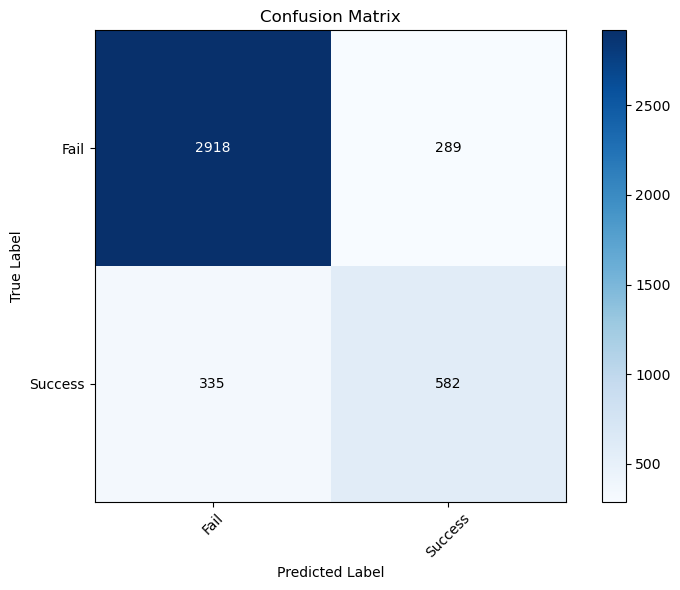

In [61]:
#Best XGBoost

best_xgb = XGBClassifier(learning_rate=0.1, max_depth=10, n_estimators = 200, scale_pos_weight=3)

best_xgb.fit(X_train, y_train)

y_pred = best_xgb.predict(X_test)
print(classification_report(y_test, y_pred))
plot_confusion_matrix(y_test, y_pred)


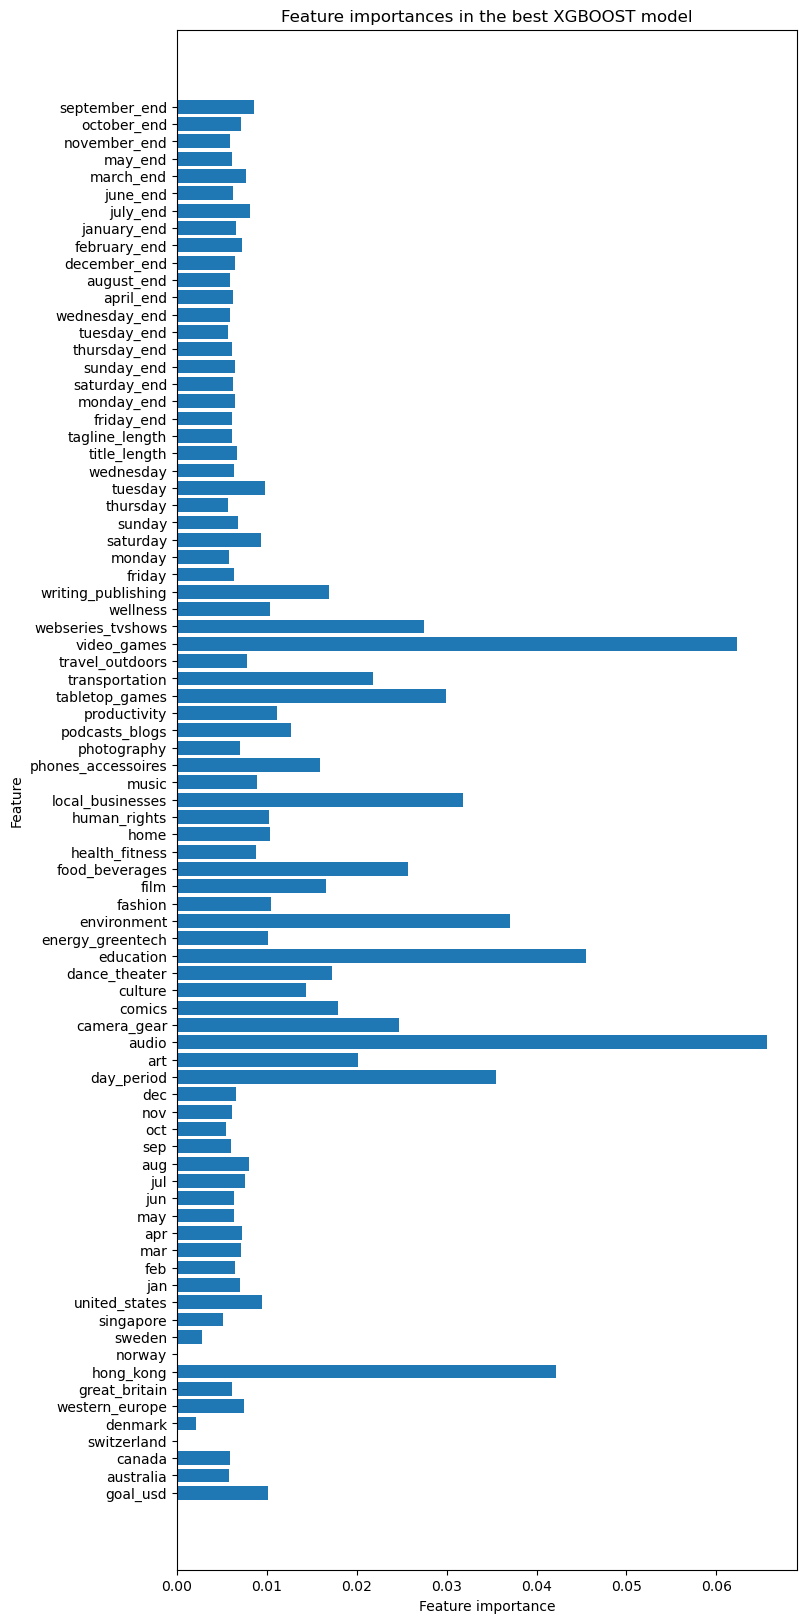

In [62]:
# Plotting feature importance
n_features = X_train.shape[1]
plt.figure(figsize=(8,20))
plt.barh(range(n_features), best_xgb.feature_importances_, align='center') 
plt.yticks(np.arange(n_features), X_train.columns.values) 
plt.title("Feature importances in the best XGBOOST model")
plt.xlabel("Feature importance")
plt.ylabel("Feature")
plt.show()